# Cross Entropy Loss and You!
> Meet multi-classification's favorite loss function

- toc: true 
- badges: true
- comments: true
- author: Wayde Gilliam
- image: images/articles/understanding-cross-entropy-loss-logo.png
- categories: [multi-classification, loss functions]

In [0]:
# only run this cell if you are in collab
!pip install git+https://github.com/fastai/fastai2 
!pip install git+https://github.com/fastai/fastcore

In [0]:
import torch
from torch.nn import functional as F
from fastai2.vision.all import *

We've been doing multi-classification since week one, and last week, we learned about how a NN "learns" by evaluating its predictions as measured by something called a "loss function."  

So for multi-classification tasks, what is our loss function?

In [0]:
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.loss_func

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


FlattenedLoss of CrossEntropyLoss()

## Negative Log-Likelihood & CrossEntropy Loss

To understand `CrossEntropyLoss`, we need to first understand something called `Negative Log-Likelihood`

### Negative Log-Likelihood (NLL) Loss

Let's imagine a model who's objective is to predict the label of an example given five possible classes to choose from.  Out predictions might look like this ...

In [0]:
preds = torch.randn(3, 5); preds

tensor([[-0.3139,  0.6737, -0.0143,  1.9929, -0.6949],
        [ 0.5285,  0.1311,  0.2628,  0.6450,  1.7745],
        [-1.7458,  2.0199, -0.1365,  1.4622, -0.0940]])

Because this is a supervised task, we know the actual labels of our three training examples above (e.g., the label of the first example is the first class, the label of the 2nd example the 4th class, and so forth)

In [0]:
targets = torch.tensor([0, 3, 4])

**Step 1**: Convert the predictions for each example into probabilities using `softmax`. This describes how confident your model is in predicting what it belongs to respectively for each class

In [0]:
probs = F.softmax(preds, dim=1); probs

tensor([[0.0635, 0.1704, 0.0856, 0.6372, 0.0433],
        [0.1421, 0.0955, 0.1089, 0.1596, 0.4939],
        [0.0126, 0.5458, 0.0632, 0.3125, 0.0659]])

If we sum the probabilities across each example, you'll see they add up to 1

In [0]:
probs.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000])

**Step 2**: Calculate the "negative log likelihood" for each example where `y` = the probability of the correct class

`loss = -log(y)`

We can do this in one-line using something called ***tensor/array indexing***

In [0]:
example_idxs = range(len(preds)); example_idxs

range(0, 3)

In [0]:
correct_class_probs = probs[example_idxs, targets]; correct_class_probs

tensor([0.0635, 0.1596, 0.0659])

In [0]:
nll = -torch.log(correct_class_probs); nll

tensor([2.7574, 1.8349, 2.7194])

**Step 3**: The loss is the mean of the individual NLLs

In [0]:
nll.mean()

tensor(2.4372)

... or using PyTorch

In [0]:
F.nll_loss(torch.log(probs), targets)

tensor(2.4372)

### Cross Entropy Loss

... or we can do this all at once using PyTorch's `CrossEntropyLoss`

In [0]:
F.cross_entropy(preds, targets)

tensor(2.4372)

As you can see, cross entropy loss simply combines the `log_softmax` operation with the `negative log-likelihood` loss

## So why not use accuracy?

In [0]:
# this function is actually copied verbatim from the utils package in fastbook (see footnote 1)
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

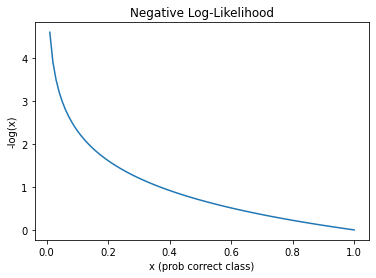

In [0]:
def f(x): return -torch.log(x)

plot_function(f, 'x (prob correct class)', '-log(x)', title='Negative Log-Likelihood', min=0, max=1)

NLL loss will be higher the smaller the probability *of the correct class*

**What does this all mean?** The lower the confidence it has in predicting the correct class, the higher the loss. It will:

1) Penalize correct predictions that it isn't confident about more so than correct predictions it is very confident about.

2) And vice-versa, it will penalize incorrect predictions it is very confident about more so than incorrect predictions it isn't very confident about

**Why is this better than accuracy?**

Because accuracy simply tells you whether you got it right or wrong (a 1 or a 0), whereast NLL incorporates the confidence as well.  That information provides you're model with a much better insight w/r/t to how well it is really doing in a single number (INF to 0), resulting in gradients that the model can actually use!

*Rember that a loss function returns a number.* That's it!

Or the more technical explanation from fastbook:

>"The gradient of a function is its slope, or its steepness, which can be defined as rise over run -- that is, how much the value of function goes up or down, divided by how much you changed the input. We can write this in maths: `(y_new-y_old) / (x_new-x_old)`. Specifically, it is defined when `x_new` is very similar to `x_old`, meaning that their difference is very small. **But accuracy only changes at all when a prediction changes from a 3 to a 7, or vice versa.** So the problem is that a small change in weights from `x_old` to `x_new` isn't likely to cause any prediction to change, so `(y_new - y_old)` will be zero. **In other words, the gradient is zero almost everywhere.**

>As a result, **a very small change in the value of a weight will often not actually change the accuracy at all**. This means it is not useful to use accuracy as a loss function. When we use accuracy as a loss function, most of the time our gradients will actually be zero, and the model will not be able to learn from that number. That is not much use at all!" {% fn 1 %}

## Summary

So to summarize, `accuracy` is a great metric for human intutition but not so much for your your model.  If you're doing multi-classification, your model will do much better with something that will provide it gradients it can actually use in improving your parameters, and that something is `cross-entropy loss`.

## References

1. https://pytorch.org/docs/stable/nn.html#crossentropyloss
2. http://wiki.fast.ai/index.php/Log_Loss
3. https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/
4. https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy
5. https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/

{{ 'fastbook [chaper 4](https://github.com/fastai/fastbook/blob/dc1bf74f2639aa39b16461f20406587baccb13b3/04_mnist_basics.ipynb)'  | fndetail: 1 }}